## Purpose of the Notebook

The purpose of this notebook is to conduct statistical inference of the parameters in the JMAK and GL models _vs._ non-linear least squares _regression_ (_e.g._ [initial_least_squares_comparison.ipynb](../data_exploration/initial_least_squares_comparison.ipynb)). Inference provides useful information regarding the distribution of the model parameters given the data, which is crucial for assessing confidence in the parameter fit.

As with the least-squares procedure, the non-linear structure of the model(s) means that obtaining analytical distributions of the model parameters is difficult, even impossible. This complication is fairly common, and the distribution of the parameters given observed data (_i.e._ the posterior) may be obtained using standard statistical numerical methods, specifically using Markov Chain Monte Carlo (MCMC) methods, and in particular the No U-Turn Samplers (NUTS). 

As with many numerical techinques, the "initial values" _i.e._ the initial "guesses" of the parameters are crucial for obtaining satisfactory results, and we'll use the least squares fitted values to inform the initial guesses & priors in the inference. 

## Model Descriptions
We suppose that $X(t,T): \mathbb{R}^2_+ \mapsto [0,1)$ is the _recrystillization fraction_, and is a function of $t$ the time and $T$, the _isothermal_ temperature, (_i.e._ the temperature at a point is independent of time).

### JMAK
The parameters of interest are the incubation time $t_{inc}$, the exponent, $n$, and the rate coefficient $b$. $A_1,B_1,A_2,B_2$ are parameters involved in the Arrhenius process description of the temperature dependence of $b$ and $t_{inc}$ on $T$. 

$$\begin{matrix}
X(t,T) = 1 - \exp{\left( -b^n (t - t_{inc})^n \right)} \\ 
b(T) = A_1 \exp{\left(B_1/T \right)} \\ 
t_{inc}(T) = A_2 \exp{\left(B_2/T \right)} 
\end{matrix}$$

### Generalized Logistic 
We suppose that the recrystillization fractionmay be modeled using a (generalized) logistic (GL) growth function. The temperature dependence follows through the Arrhenius process modeled for the growth rate $B$ and starting time $M$.


$$
\begin{matrix}
X(t,T) = \frac{1}{(1 + e^{-B (t - M)})^{1/\nu}} \\ 
B(T) = A_1 \exp{\left(B_1/T \right)} \\ 
M(T) = A_2 \exp{\left(B_2/T \right)} 
\end{matrix}
$$


Note that because the parameters tend to be on very different scales, we employ a log re-parameterization. That is, for example, 


$$
\ln{B(T)} = \ln{A_1} + \frac{B_1}{T} = a_1 + \frac{B_1}{T} \implies B(T) = \exp{\left( a_1 + \frac{B_1}{T}\right)}
$$

where $a_1 = \ln{A_1}$

## Statistical Inference Model
As before, we consider each data set independently. Let $\hat{\mathbf{X}} = f(\mathbf{t},\mathbf{T}; \theta) $ be the model predicted values at a vector of times and temperatures with parameter vector $\theta$ using either the JMAK or GL model. We suppose that

$$
\mathbf{X} \sim \mathcal{N}_T(\mathbf{\hat{X}},\sigma^2 \Xi) 
$$

Where $\Xi = \Sigma + \sigma^2 \mathbf{I}$ is a diagonal matrix with additive known experimental error, $\Sigma$ and $\sigma^2$ is some unknown model inadequecy.

We want to obtain the distribution of the parameters $\theta$ after observing the data $\mathbf{X,t,T}$. Using Baye's rule:

$$
\begin{matrix}
p(\theta| \mathbf{X,t,T}) \propto \mathcal{L}(\mathbf{X,t,T} | \theta)p(\theta) \\ 
\mathcal{L}(\mathbf{X,t,T} | \theta) = \mathcal{N}_T(\mathbf{\hat{X} - X},\Xi) \\ 
\hat{\mathbf{X}} = f(\mathbf{t},\mathbf{T}; \theta)
\end{matrix}
$$

$$
\begin{matrix}
p(\theta| \mathbf{X,t,T}) \propto \mathcal{L}(\mathbf{X,t,T} | \theta)p(\theta) \qquad
\mathcal{L}(\mathbf{X,t,T} | \theta) = \mathcal{N}_T(\mathbf{\hat{X} - X},\Xi)  \\ 
\theta_i \sim \mathcal{N}(\mu_i,\sigma^2_i) \quad \implies \quad p(\theta) = \prod_{i = 1}^5 p_i(\theta_i)
\end{matrix}
$$


Focusing on the JMAK model, we have $\theta = [a_1,B_1,a_2,B_2,n]$. We can use our prior estimates of $\theta$ obtained from [arrhenius_process_estimation.ipynb](arrhenius_process_estimation.ipynb) and [initial_least_squares_comparison.ipynb](../data_exploration/initial_least_squares_comparison.ipynb) to independently set the priors using $\theta_i \sim \mathcal{N}(\mu_i,\sigma^2_i)$. The same approach is used in GL model inference.

In [19]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc

import pickle
rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])
import numpyro
from jax import random
import jax.numpy as jnp
from numpyro.distributions import Normal, LogNormal, TruncatedNormal
from numpyro.infer import init_to_mean,init_to_value,init_to_sample,init_to_feasible,init_to_median
from typing import Callable
import dill
import jax

#path stuff
from pathlib import WindowsPath, PosixPath
import sys
PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('../')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
MODEL_PATH = PARENT_DIR.joinpath('.model')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference')  
MODEL_INFERENCE_PATH = PARENT_DIR.joinpath('.model_inference')
GIT_IMAGE_PATH = PARENT_DIR.joinpath('.git_images')
sys.path.append(str(PARENT_DIR))
from common_util import setup_axis_default,jmak_fit_model_setup,gl_fit_model_setup,get_model_params, \
    resampled_adam,get_data_label,get_data_multiplier
from inflib import jmak_numpyro_model,glm_numpyro_model,gl_likelihood,jmak_likelihood, JMAKNumpyro,GLNumpyro

### Model Inference
Below is a cell that samples the parameter posterior of the JMAK and GL model for a specific data set. Some experimentation and examination of the $\hat{r}$ diagnostic for each inference confirms that the inference parameters (the number of warmup samples, number of samples, initial conditions, ect...) provide satisfactory results. The results of each inference are written to a file for later analysis.

In [ ]:
rng_key = random.PRNGKey(155)
rng_key, rng_key_ = random.split(rng_key)


#specify the model name and the file containing the data we are fitting to
model_name = 'Generalized Logistic_{}'
model_setup = jmak_fit_model_setup if 'JMAK' in model_name else gl_fit_model_setup
numpyro_model = jmak_numpyro_model if 'JMAK' in model_name else glm_numpyro_model    
ep_param = 'n' if 'JMAK' in model_name else 'nu'


for ff in ['alfonso_data/moderate_roll.csv']: 

    file = DATA_DIR.joinpath(ff)

    #same function as in initial_least_squares_comparison.ipynb
    t,T,X,df,bounds,p0 = model_setup(str(file), mult = get_data_multiplier(file))

    #estimate the standard deviation of the parameters
    if bounds is None:
        bounds = np.load(MODEL_PATH.joinpath(f'{model_name.format(get_data_label(file))}_bounds.npy'))
    
    pstd= (bounds[:,1] - bounds[:,0])/4
    pstd = pstd[1:]

    #read in least squares estimates made in initial_least_squares_comparison.ipynb
    with open(MODEL_PATH.joinpath(f'{model_name.format(get_data_label(file))}_weighted.pkl'),'rb') as f:
        a1,B1,a2,B2,exp_term = get_model_params(pickle.load(f))

    print(exp_term)
    #initialize the model with the least squares estimates
    init_values = {'a1': a1, 'a2': a2, 'B1': B1, 'B2': B2, ep_param: exp_term, 'sigma': 0.1}
    p0 = np.array([a1,B1,a2,B2,exp_term])

    #setup the NUTS kernel 
    nuts_kernel = numpyro.infer.NUTS(numpyro_model,init_strategy= init_to_median,max_tree_depth = 40)
    mcmc = numpyro.infer.MCMC(
        nuts_kernel,
        num_samples=80000,
        num_warmup=20000,
        num_chains= 1
    )

    #run the MCMC
    mcmc.run(rng_key_,jnp.array(t),jnp.array(T),jnp.array(X),jnp.array(df['std'].to_numpy()),
            jnp.array(p0),jnp.array(pstd),init_params= init_values)
    mcmc.print_summary()

    #save the samples
    posterior_samples = mcmc.get_samples()
    with open(INFERENCE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_trunc_normal_samples.pkl'),'wb') as f:
        pickle.dump(posterior_samples,f)


    


0.05810529491972607


sample: 100%|██████████| 100000/100000 [05:23<00:00, 308.65it/s, 91 steps of size 2.21e-02. acc. prob=0.80]    


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        B1 -69679.01    942.97 -69608.84 -71460.29 -68214.78    326.86      1.00
        B2 -15255.49  28319.74 -14310.75 -64728.59  27479.82    796.44      1.00
        a1     34.61      0.64     34.57     33.57     35.76    346.70      1.00
        a2     -3.63     19.62     -3.77    -37.06     27.29    330.99      1.00
        nu      0.06      0.01      0.06      0.04      0.09   2115.91      1.00
     sigma      0.10      0.01      0.10      0.08      0.12   2978.99      1.00

Number of divergences: 224


### Maximum Likelihood Estimation
Estimate the parameters with maximum likelihood. We don't really care about the MAP because the "priors" used here are just to help the inference, they don't reflect our belief in the distribution of the parameters. I use the ADAM optimizer with multiple restartsm taking the best overall likelihood estimate as the true estimate. The optimizer is starting at points drawn from the posterior (above) with maximum likelihood.

In [21]:
model_name = 'Generalized Logistic_{}'
likelihood_func = jmak_likelihood if 'JMAK' in model_name else gl_likelihood
model_setup = jmak_fit_model_setup if 'JMAK' in model_name else gl_fit_model_setup
ep_param = 'n' if 'JMAK' in model_name else 'nu'
NumpyroModel = JMAKNumpyro if 'JMAK' in model_name else GLNumpyro

for ff in ['alfonso_data/moderate_roll.csv']:     
    file = DATA_DIR.joinpath(ff)

    #we want to minimize the negative likelihood
    def opt_func(params: np.ndarray):
        return -likelihood_func(params,t,T,X,std)

    #setup the model data
    t,T,X,df,bounds,p0 = jmak_fit_model_setup(file, mult = get_data_multiplier(file))
    t,T,X,std = jnp.array(t),jnp.array(T),jnp.array(X),jnp.array(df['std'].to_numpy())
    pstd= (bounds[:,1] - bounds[:,0])/4
    pstd = pstd[1:]
    #read in the posterior samples
    model_params = ['a1','B1','a2','B2',ep_param,'sigma']
    with open(INFERENCE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_trunc_normal_samples.pkl'),'rb') as f:
        posterior_samples = pd.DataFrame.from_dict(pickle.load(f))[model_params]

    #transform the sigma parameter to the log scale so it cant go netative during optimization
    posterior_samples['sigma'] = np.log(posterior_samples['sigma'])

    #this is hacky as hell, basically initialize the optimization with the number
    #of samples from the parameter posterior that have the greatest likelihood
    #this sortof implies that the maximum likelihood and MAP estimate are the same, which is not not true
    #but the estimate is good enough for our purposes
    NUM_SAMPLES = 50
    posterior_likelihood = jax.vmap(opt_func,in_axes = (0))(posterior_samples[model_params].to_numpy())
    init_samples = posterior_samples.iloc[np.argsort(posterior_likelihood)[:NUM_SAMPLES]][model_params].to_numpy()
    init_samples = np.concatenate([posterior_samples.mean(axis = 0).to_numpy()[np.newaxis,:],init_samples],axis = 0)
    opt_params,posterior_value = resampled_adam(init_samples,opt_func,lr = 2.5e-4,opt_iter = int(2e3))
    opt_params = np.array(opt_params)
    opt_params[-1] = np.exp(opt_params[-1])
    posterior_samples['sigma'] = np.exp(posterior_samples['sigma'])

    #package the results into a summary data frame and write to file
    inf_summary = pd.DataFrame({'mean': posterior_samples.mean(axis = 0),
                            'std': posterior_samples.std(axis = 0),
                            'ml': opt_params},
                            index = model_params)

    inf_summary.to_csv(INFERENCE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_trunc_normal_params.csv'))

    with open(INFERENCE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_trunc_normal_samples.pkl'),'rb') as f:
        posterior_samples = pickle.load(f)

    numpyro_model = NumpyroModel(posterior_samples,(p0,pstd),ml_est = inf_summary['ml'].to_dict())
    numpyro_model.dump(MODEL_INFERENCE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_trunc_normal.pkl'))


Optimizing: 100%|██████████| 51/51 [00:15<00:00,  3.31it/s]


### Posterior Predictive Inference

Now that we have samples from the model parameter posteriors, and an estimate of the maximum likelihood, It's helpful to examine the posterior predictive distribution, that is, the distribution of model predicted results at new dependent variables. More precisisely, we want:

$$
p(X^* | t^*, T^*, \theta)
$$

Where $X^*$ is the recrystillization fraction correponsding to some new $t^*,T^*$ time and temperature pair. We can sample this by simply drawing samples form the posterior and visualizing the ensemble using numerical highest posterior density intervals. In general, there is little visual difference between the GL and JMAK models, both in the estimates of maximum likelihood, as well as the predicted confidence intervals. 

No standard deviation column found, using 0.001 for all values
No standard deviation column found, using 0.001 for all values


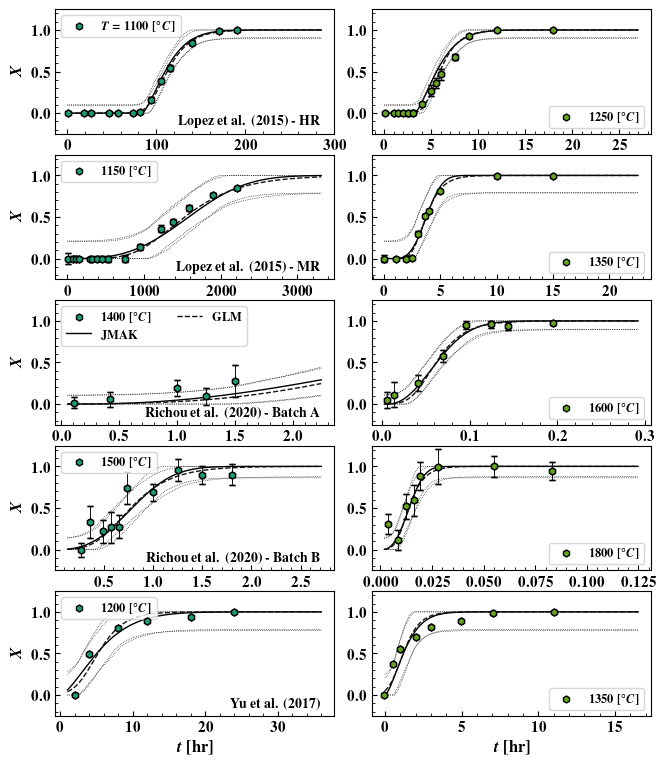

In [22]:
from common_util import _FILE_TO_LABEL as file_to_label
from matplotlib.lines import Line2D
from inflib import RxKineticNumpyro

rng_key = random.PRNGKey(155)
rng_key, rng_key_ = random.split(rng_key)

def plot_posterior_prediction(ax: plt.Axes,
                              numpyro_model: RxKineticNumpyro,
                              temperature: float,
                              exp_data: pd.DataFrame,
                              style: str = '-',
                              pred_color: str = 'k') -> None:
    
    """
    helper function to plot posterior prediction summaries.
    """
    _, subkey = random.split(rng_key_)
    data = exp_data.loc[exp_data['temperature'] == temperature]
    t = np.linspace(data['time'].min()*0.5,data['time'].max()*1.5,300)

    #sample from the posterior predictive
    lower, upper = numpyro_model.predictive_confidence_interval(
        rng_key_,
        t=jnp.asarray(t),
        T=(temperature + 273.15)*jnp.ones_like(t),
        std=jnp.zeros_like(t),   # or your actual df['std']
        alpha=0.95
    )
    ml_pred = numpyro_model.ml_prediction(t,(temperature + 273.15)*np.ones_like(t))

    #Visualize the results using ML + HPDI
    ax.plot(t/3600,ml_pred,color = pred_color,lw = 1.0,ls = style)
    ax.plot(t/3600,lower,color = 'k',lw = 0.5,ls = ':')
    ax.plot(t/3600,upper,color = 'k',lw = 0.5,ls = ':')  
    

def plot_experimental_data(ax: plt.Axes,
                           exp_data: pd.DataFrame,
                           temperature: float,
                           color: str,
                           first_label = True,
                           make_label = True) -> None:
    
    """
    helper function to plot data.
    """

    label = r'\textbf{$T = ' + f'{temperature}$' + r' [$^\circ C $]}' if first_label else  r'\textbf{' rf'${temperature}$' + r' [$^\circ C $]}'
    data = exp_data.loc[exp_data['temperature'] == temperature]
    
    #plot the data and error bars
    ax.scatter(data['time']/3600,data['X'],facecolor = color,s = 25,
            edgecolor = 'k',zorder = 100,marker = 'h',
            label = label if make_label else None)
    ax.errorbar(data['time']/3600,data['X'],yerr = data['std'],color = 'k',
                fmt = 'none',capsize = 2,elinewidth = 0.5)

#plot the posterior predictive for the JMAK and GLM models for some sample isothermal temperatures
fig,axes = plt.subplots(nrows = 5,ncols = 2,figsize = (6.5,7.5))

temperatures  = {'alfonso_data/highly_rolled.csv': [1100,1250],
                'alfonso_data/moderate_roll.csv': [1150,1350],
                'richou_data/batch_a_data.csv': [1400,1600],
                'richou_data/batch_b_data.csv': [1500,1800],
                 'yu_data/data.csv': [1200,1350]}

files = [file for file in file_to_label if "shah" not in file.lower()]
temperatures = {get_data_label(DATA_DIR.joinpath(file)): temps for file,temps in temperatures.items()}

for k,model_name,NumpyroModel,model_setup,ep_param,color,style in zip(range(2),['JMAK_{}','Generalized Logistic_{}'],
                                                                         [JMAKNumpyro,GLNumpyro],
                                                                        [jmak_fit_model_setup,gl_fit_model_setup],
                                                                        ['n','nu'],
                                                                        ['k',(20/255,20/255,20/255)],
                                                                        ['-','--']):
    
    for i,file in enumerate(files): #count rows/datasets
        #same function as in initial_least_squares_comparison.ipynb
        t,T,X,df,bounds,p0 = model_setup(str(file), mult = get_data_multiplier(file))
        numpyro_model = NumpyroModel.load(MODEL_INFERENCE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_trunc_normal.pkl'))
                
        for j,plot_temperature,exp_color in zip(range(2),temperatures[get_data_label(file)],plt.get_cmap('Dark2')([0.1,0.6])): #count columns/temperatures
            plot_posterior_prediction(axes[i,j],numpyro_model,plot_temperature,df,style = style,pred_color = color)
            plot_experimental_data(axes[i,j],df,plot_temperature,exp_color,first_label = (i == 0 and j == 0),
                                   make_label = k == 0)


for ax,data_label in zip(axes[:,0],file_to_label.values()):
    ax.set_ylabel(r'$X$',fontsize = 12)
    ax.text(0.95, 0.05, r'\textbf{' + data_label + '}', ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

for ax in axes[-1,:]:
    ax.set_xlabel(r'$t$ \textbf{[hr]}',fontsize = 12)

for i in range(5):
    for j in range(2):
        setup_axis_default(axes[i,j])
        axes[i,j].set_ylim([-0.25,1.25])
        if i == 2 and j == 0: 
            legend_patches  = [Line2D([],[],color = 'k',lw = 1.0,ls = '-',label = r'\textbf{JMAK}'),
                            Line2D([],[],color = 'k',lw = 1.0,ls = '--',label = r'\textbf{GLM}')]
            handles,axes_labels = axes[i,j].get_legend_handles_labels()
            axes[i,j].legend(handles + legend_patches,
                             axes_labels + [r'\textbf{JMAK}',r'\textbf{GLM}'],
                             fontsize = 9,ncol = 2,loc = 'upper left')
        elif j == 1:
            axes[i,j].legend(fontsize = 9,ncol = 2,loc = 'lower right')
        else:
            axes[i,j].legend(fontsize = 9,ncol = 2,loc = 'upper left')
        

fig.tight_layout(pad = 0.15) 
fig.savefig(GIT_IMAGE_PATH.joinpath('posterior_predictive_comparison_truncated_normal.svg'),bbox_inches = 'tight')


### Parameter Marginal Posterior Visualization

It is useful to examine the marginal posterior distributions of the parameters $a_1,B_1,a_2,B_2,n$ for the JMAK model or $a_1,B_1,a_2,B_2,\nu$ for the GL model, as shown below. The samples are plotted as a histogram, shown with the initial parameter guesses obtained using least squares, as well as the mean values. A kde model is fit to the samples, and stored for use in later analysis.

In general, the mean values computed from the posterior samples, and indeed the maximum likelihood estimates, can differ significnatly from the initial least squares estimates. 

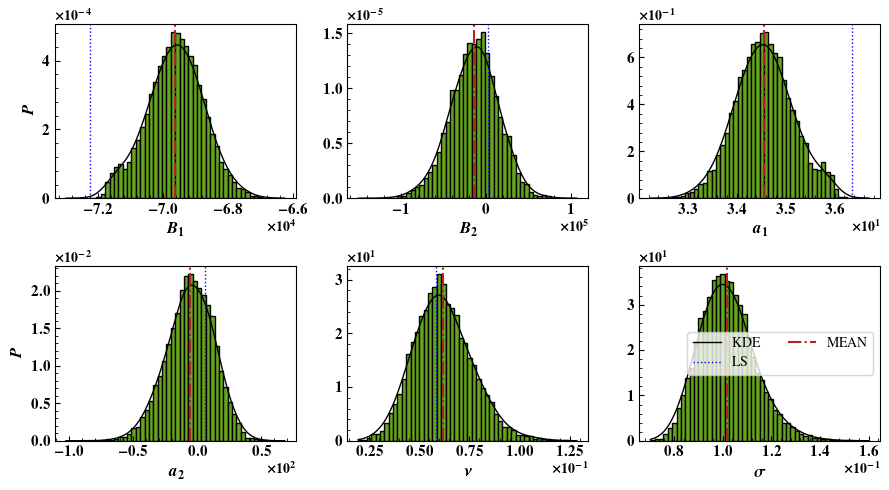

In [28]:
from scipy.stats import gaussian_kde

#setup
file = DATA_DIR.joinpath('alfonso_data/moderate_roll.csv')
model_name = 'Generalized Logistic_{}'
with open(INFERENCE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_trunc_normal_samples.pkl'),'rb') as f:
    posterior_samples = pickle.load(f)

#get inference summary from file
inf_summary = pd.read_csv(INFERENCE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_trunc_normal_params.csv'),index_col = 0)

fig,axes = plt.subplots(figsize = (9,5),nrows = 2,ncols = 3)
xlabels = {'a1': r'$a_1$','a2': r'$a_2$', 'B1': r'$B_1$', 'B2': r'$B_2$', 'n': r'$n$','sigma': r'$\sigma$'} \
if 'JMAK' in model_name else {'a1': r'$a_1$','a2': r'$a_2$', 'B1': r'$B_1$', 'B2': r'$B_2$', 'nu': r'$\nu$','sigma': r'$\sigma$'}

#read in least squares estimates made in initial_least_squares_comparison.ipynb
with open(MODEL_PATH.joinpath(f'{model_name.format(get_data_label(file))}_weighted.pkl'),'rb') as f:
    a1,B1,a2,B2,nu = get_model_params(pickle.load(f))

#initialize the model with the least squares estimates
init_values = {'a1': a1,'a2': a2,'B1': B1,'B2': B2,'nu': nu,'sigma': np.nan} if 'Generalized Logistic' in model_name else {'a1': a1,'a2': a2,'B1': B1,'B2': B2,'n': nu,'sigma': np.nan}

#plot the posterior samples and the KDE,initial LS estimates, and Mean estimates
kde = {}
for ax,key in zip(np.ravel(axes),posterior_samples.keys()):
    setup_axis_default(ax)
    ax.hist(np.array(posterior_samples[key]),bins = 50,edgecolor = 'k',
            color = plt.get_cmap('Dark2')(0.5),density = True,lw = 0.25)
    
    kde[key] = gaussian_kde(np.array(posterior_samples[key]),bw_method = 0.35)

    x = np.linspace(np.min(posterior_samples[key]),
                    np.max(posterior_samples[key]),1000)
    
    pde_plot = kde[key](x)

    ax.plot(x,pde_plot,color = 'k',lw = 1.0,label = 'KDE')
    ax.axvline(init_values[key],color = 'blue',lw = 1.0,ls = ':',label = 'LS')
    ax.axvline(inf_summary.loc[key,'mean'],color = 'firebrick',lw = 1.5,ls = '-.',label = 'MEAN')
    ax.set_xlabel(xlabels[key],fontsize = 12)
    ax.ticklabel_format(axis = 'both',style = 'sci',scilimits = (0,0))   

#final formatting
axes[-1,-1].legend(fontsize = 10,ncols = 2)
for i in range(2):
    axes[i,0].set_ylabel('$P$',fontsize = 12)

fig.tight_layout()

#store KDEs for later visualization and analysis
with open(INFERENCE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_trunc_normal_kde.pkl'),'wb') as f:
    dill.dump(kde,f)



### Parameter Posterior Comparison Visualization 

As some final analysis, lets visualize the parameter marginal posteriors and compare for each dataset, shown below. There is clear distinction between $a_1,B_1,n$ in both the JMAK and GL models, and they seem to play the same role as the means follow the same relative ordering between studies. The parameters $a_2$ and $B_2$ are much more varied, though they seem to cluster slightly more for the GL model then the JMAK model. Finally, there is more distinction between probability distributions for $\nu$ in the GL model then there is for $n$.

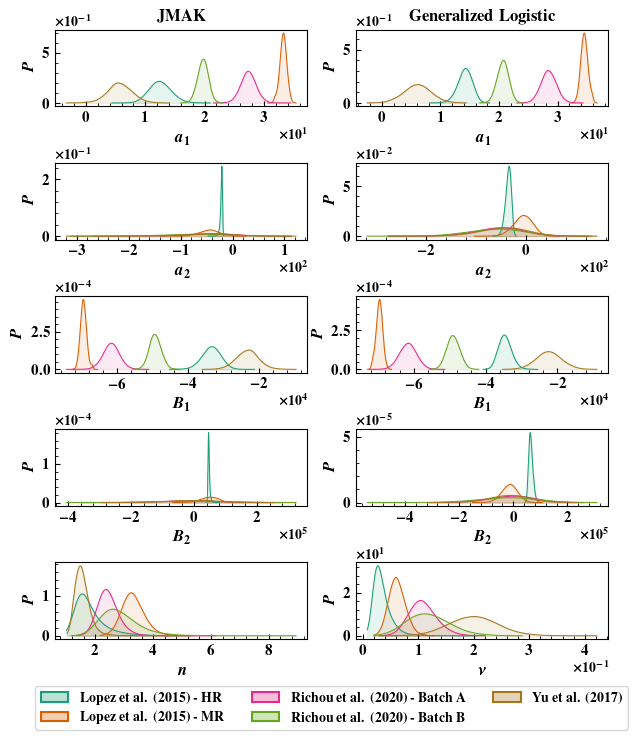

In [29]:
from common_util import _FILE_TO_LABEL as file_to_label
import matplotlib.patches as mpatches

fig,axes = plt.subplot_mosaic("""
                              01
                              23
                              45
                              67
                              89
                              AA
                              """,figsize = (6.5,7.25),
                              height_ratios= [1,1,1,1,1,0.33])

legend_axes = axes['A']
axes = np.array([axes[key] for key in axes.keys() if key != 'A']).reshape(5,2)

colors = plt.get_cmap('Dark2')(np.linspace(0,1,len(file_to_label)))
keys = [key for key in file_to_label.keys() if 'shah' not in key]

for k,model_name in enumerate(['JMAK_{}','Generalized Logistic_{}']):
    parameters = {'a1': r'$a_1$','a2': r'$a_2$', 'B1': r'$B_1$', 'B2': r'$B_2$', 'n': r'$n$'} \
    if 'JMAK' in model_name else {'a1': r'$a_1$','a2': r'$a_2$', 'B1': r'$B_1$', 'B2': r'$B_2$', 'nu': r'$\nu$'}

    for i,file in enumerate(keys):
        #read stored KDES + summary stats of parameters for later visualization and analysis
        with open(INFERENCE_PATH.joinpath(f'{model_name.format(file_to_label[file])}_trunc_normal_kde.pkl'),'rb') as f:
            model_kde = dill.load(f)
            
        #read in posterior samples from file
        with open(INFERENCE_PATH.joinpath(f'{model_name.format(file_to_label[file])}_trunc_normal_samples.pkl'),'rb') as f:
            posterior_samples = pickle.load(f)
        
        #get inference summary from file
        inf_summary = pd.read_csv(INFERENCE_PATH.joinpath(f'{model_name.format(file_to_label[file])}_trunc_normal_params.csv'),index_col = 0)
        for ax,param in zip(axes[:,k],parameters):
            
            x = np.linspace(np.min(posterior_samples[param]),
                        np.max(posterior_samples[param]),1000)
            pde_plot = model_kde[param](x)
            ax.plot(x,pde_plot,color = colors[i],label = file_to_label[file],lw = 0.75)
            ax.fill_between(x,0,pde_plot,color = colors[i],alpha = 0.1)

    for ax,p in zip(axes[:,k],parameters.values()):
        setup_axis_default(ax)
        ax.ticklabel_format(axis = 'both',style = 'sci',scilimits = (0,0))   
        ax.set_xlabel(p,fontsize = 12)
        ax.set_ylabel('$P$',fontsize = 12)

axes[0,0].set_title(r'\textbf{JMAK}',fontsize = 12)
axes[0,1].set_title(r'\textbf{Generalized Logistic}',fontsize = 12)

legend_patches  = [mpatches.Patch(facecolor = tuple(list(color)[:-1] + [0.3]),edgecolor  = color,
                                  label = r'\textbf{' + file_to_label[key] + '}',lw = 1.5) for color,key in zip(colors,keys)]
legend_axes.legend(handles = legend_patches,fontsize = 10,ncol = 3,loc = 'center')
legend_axes.axis('off')

fig.tight_layout(pad = 0.25)
fig.savefig(GIT_IMAGE_PATH.joinpath('posterior_kde_comparison_truncated_normal.svg'),bbox_inches = 'tight')

### Intra Parameter Correlation 

Visually, it seems like there is a decent amount of correlation between parameters $a_1,B_1,n/\nu$ from the posterior PDF plots between models. This is confirmed by the correlation plots below:

### JMAK Observations:

1. $a_1$ and $B_1$ are nearly perfectly negatively correlated and have very low uncertainty in their values.
2. $a_1$ and $n$ and $B_1$ and $a_1$ are reasonably positively correlated.
3. There is no obvious correlation between $a_2,B_2$ and any of the other variables.

### GLM Observations:

1. $a_1$ and $B_1$ are nearly perfectly negatively correlated and have very low uncertainty in their values.
2. $a_1$ and $n$ and $B_1$ and $a_1$ are reasonably positively correlated, though the data from ALfonso $et al$ HR breaks this trend.
3. There is no obvious correlation between $a_2,B_2$ and any of the other variables, though the values are more tightly clustered than in the JMAK model.

The reasonable conclusion is that subsets of the parameters are linearly related between datasets, which in turn suggests that a linear _latent_ model exists that could allow fitting across all data sets. This idea is developed in [jmak_hierarchical_model.ipynb](jmak_hierarchical_model).

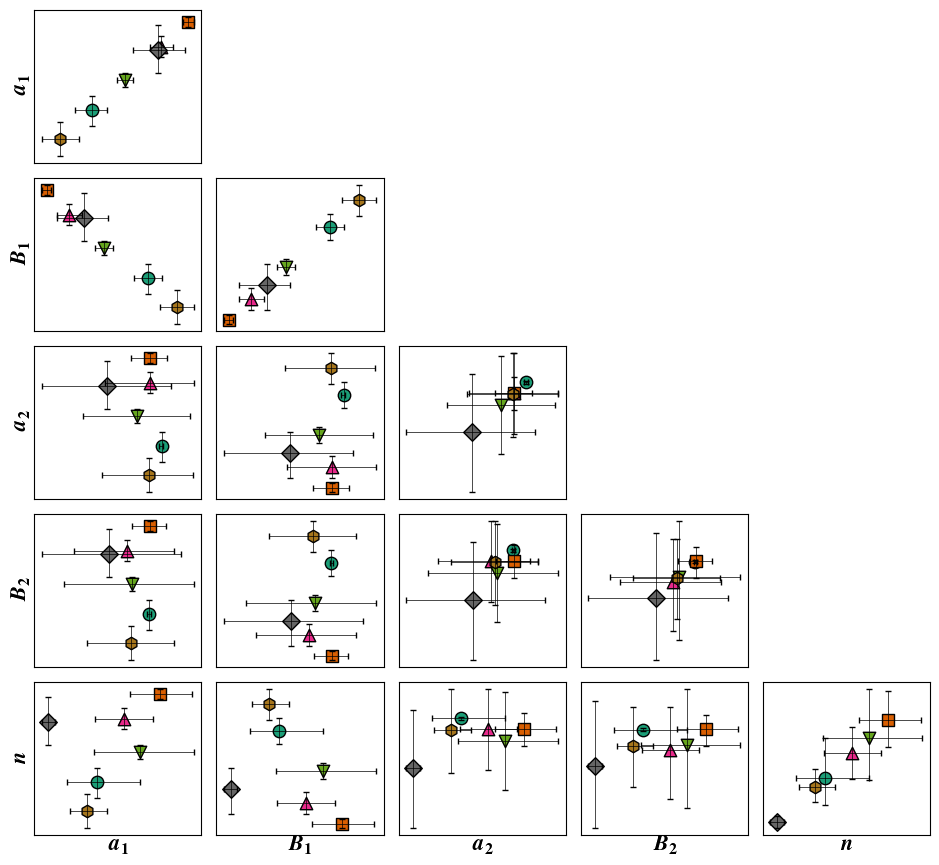

In [30]:
from common_util import hdi
import math 

model_name = 'JMAK_{}'

#store loaded results
inference_results = {}

for data_name in file_to_label.values():
    inf_params = pd.read_csv(INFERENCE_PATH.joinpath(f'{model_name.format(data_name)}_trunc_normal_params.csv'),index_col = 0).T
    
    #load the samples from a file
    with open(INFERENCE_PATH.joinpath(f'{model_name.format(data_name)}_trunc_normal_samples.pkl'),'rb') as f:
        samples = pd.DataFrame.from_dict(pickle.load(f))
    
    #compute the HDI
    for j,col in enumerate(list(samples.columns)):
        for label,ci in zip(['lower','upper'],hdi(samples[col].to_numpy(),0.95).squeeze()):
            inf_params.loc[label,col] = ci
    
    inference_results[data_name]  = inf_params.T

#setup plot
model_params = ['a1','B1','a2','B2','n'] if 'JMAK' in model_name else ['a1','B1','a2','B2','nu']
fig,axes = plt.subplots(nrows = len(model_params),
                      ncols = len(model_params),
                      figsize = (9.5,8.75))

#formatting for the plot

colors = plt.get_cmap('Dark2')(np.linspace(0,1,len(file_to_label)))
ylabels = {'a1':r'$a_1$','B1':r'$B_1$','a2': r'$a_2$','B2':r'$B_2$','n':r'$n$'} if 'JMAK' in model_name \
    else {'a1':r'$a_1$','B1':r'$B_1$','a2': r'$a_2$','B2':r'$B_2$','nu':r'$\nu$'}
symbols = np.array(['o','s','^','v','h','D'])

#plot the intra model correlation results
for i,param1 in enumerate(model_params):
    for j,param2 in enumerate(model_params[:i+1]):
        for k,data_name in enumerate(file_to_label.values()):
            ml_params = inference_results[data_name]
            xerr  = np.abs(ml_params.loc[param1,['mean']].to_numpy() - ml_params.loc[param1,['lower','upper']].to_numpy())
            yerr = np.abs(ml_params.loc[param2,['mean']].to_numpy() - ml_params.loc[param2,['lower','upper']].to_numpy())
             
            axes[i,j].scatter(ml_params.loc[param1,'mean'],ml_params.loc[param2,'mean'],color = colors[k],
                    marker = symbols[k],s = 80,edgecolor = 'k')
            axes[i,j].errorbar(ml_params.loc[param1,'mean'],ml_params.loc[param2,'mean'],
                        yerr= yerr[:,np.newaxis],xerr = xerr[:,np.newaxis],
                        elinewidth = 0.5,capsize = 2,ls = 'none',color = 'k')

        if i == len(model_params) - 1:
            axes[i,j].set_xlabel(ylabels[param2],fontsize = 16,labelpad = 0)

        if j == 0:
            axes[i,j].set_ylabel(ylabels[param1],fontsize = 16,labelpad = 3)
        setup_axis_default(axes[i,j])
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

    for j in range(i+1,len(model_params)):
        axes[i,j].axis('off')

fig.tight_layout()

In [9]:
rng_key = random.PRNGKey(155)
rng_key, rng_key_ = random.split(rng_key)
from common_util import _EXT_FILE_TO_LABEL as ext_file_to_label
from numpyro.distributions import Uniform

def jmak_numpyro_model(t: jnp.ndarray,
                      T: jnp.ndarray,
                      X: jnp.ndarray,
                      std: jnp.ndarray,
                      plow: jnp.ndarray,
                      phigh: jnp.ndarray) -> None:
    """
    numpyro/jax numpy compatible model for the JMAK model
    """

    # priors
    a1 = numpyro.sample('a1',Uniform(plow[0],phigh[0]))
    a2 = numpyro.sample('a2',Uniform(plow[2],phigh[2]))
    B1 = numpyro.sample('B1',Uniform(plow[1],phigh[1]))
    B2 = numpyro.sample('B2',Uniform(plow[3],phigh[3]))
    mean_n = plow[4] + (phigh[4] - plow[4])/2   
    n = numpyro.sample('n',LogNormal(mean_n ))

    sigma = numpyro.sample('sigma',numpyro.distributions.Exponential(10.0))

    # arrhenius equations
    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)

    #model prediction
    Xhat = 1.0 - jnp.exp(-b**n*(jnp.where(t > t_inc, t,t_inc) - t_inc)**n)
    
    # likelihood
    with numpyro.plate("data", t.shape[0]):
        numpyro.sample('obs',TruncatedNormal(Xhat,scale = sigma + std,low = 0.0,high = 1.0),obs = X)

#specify the model name and the file containing the data we are fitting to
model_name = 'JMAK_{}'
model_setup = jmak_fit_model_setup if 'JMAK' in model_name else gl_fit_model_setup
numpyro_model = jmak_numpyro_model if 'JMAK' in model_name else glm_numpyro_model    
ep_param = 'n' if 'JMAK' in model_name else 'nu'
init_values = {'a1': [], 'a2': [], 'B1': [], 'B2': [], ep_param: []}
total_bounds = []
for ff in ['alfonso_data/moderate_roll.csv','alfonso_data/highly_rolled.csv','richou_data/batch_b_data.csv','richou_data/batch_a_data.csv','yu_data/data.csv','shah_data/data.csv']:
    file = DATA_DIR.joinpath(ff)

    #same function as in initial_least_squares_comparison.ipynb
    t,T,X,df,bounds,p0 = model_setup(str(file), mult = get_data_multiplier(file))

    #estimate the standard deviation of the parameters
    if bounds is None:
        bounds = np.load(MODEL_PATH.joinpath(f'{model_name.format(get_data_label(file))}_bounds.npy'))
    
    total_bounds.append(bounds[...,np.newaxis])

    #read in least squares estimates made in initial_least_squares_comparison.ipynb
    with open(MODEL_PATH.joinpath(f'{model_name.format(get_data_label(file))}_weighted.pkl'),'rb') as f:
        a1,B1,a2,B2,exp_term = get_model_params(pickle.load(f))
        init_values['a1'].append(a1)
        init_values['a2'].append(a2)
        init_values['B1'].append(B1)
        init_values['B2'].append(B2)
        init_values[ep_param].append(exp_term)

for key in init_values.keys():
    init_values[key] = np.array(init_values[key]).mean()

init_values['sigma'] = 0.1
#initialize the model with the least squares estimates

p0 = np.array([init_values[key] for key in ['a1','B1','a2','B2',ep_param]])
total_bounds = np.concatenate(total_bounds,axis = -1)   
bounds = np.concatenate([total_bounds.min(axis = (1,2))[:,np.newaxis],
                         total_bounds.max(axis = (1,2))[:,np.newaxis]],axis = 1)

spread = np.abs(bounds[:,1] - bounds[:,0])/2
spread = spread[1:]
lower = p0[:-1] - spread
upper = p0[:-1] + spread
lower = np.concatenate([lower,np.array([0.0])])
upper = np.concatenate([upper,np.array([2.0])])

#setup the NUTS kernel 
    #setup the NUTS kernel 
nuts_kernel = numpyro.infer.NUTS(numpyro_model)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_samples=20000,
    num_warmup=100000,
    num_chains= 1,
)

for file,data_label in ext_file_to_label.items():
    print(data_label)
    df = pd.read_csv(file)
    t = df['time'].to_numpy()
    T = df['temperature'].to_numpy() + 273.15
    X = df['X'].to_numpy()
    std = df['std'].to_numpy()

    #run the MCMC
    mcmc.run(rng_key_,jnp.array(t),jnp.array(T),jnp.array(X),jnp.array(std),
            jnp.array(lower),jnp.array(upper),init_params= init_values)
    mcmc.print_summary()

    #save the samples
    posterior_samples = mcmc.get_samples()
    with open(INFERENCE_PATH.joinpath(f'{data_label}_single_trunc_normal_samples.pkl'),'wb') as f:
        pickle.dump(posterior_samples,f)


No standard deviation column found, using 0.001 for all values
K-doped 3%Re W


c:\Users\micha\OneDrive\Documents\projects\modeling_tungsten\recrystallization\model_inference\..\common_util.py:254: UserWarning: [Errno 2] No such file or directory: 'c:\\Users\\micha\\OneDrive\\Documents\\projects\\modeling_tungsten\\recrystallization\\model_inference\\..\\.model\\log_b_Shah et al. (2021)_last_2.pkl'
  warnings.warn(str(fe))
sample: 100%|██████████| 120000/120000 [03:40<00:00, 544.91it/s, 95 steps of size 1.00e-02. acc. prob=0.56]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        B1 -73136.58  16596.49 -71325.34 -97967.34 -54063.26    162.44      1.01
        B2 -48953.31 126240.42 -80076.59 -220708.80 147950.02    155.47      1.00
        a1     35.08      9.05     33.86     23.19     49.31    173.51      1.01
        a2    -71.53     64.29    -80.26   -171.73     21.49    122.38      1.00
         n      2.07      1.34      1.56      0.56      4.00     79.58      1.02
     sigma      0.04      0.02      0.03      0.01      0.07    142.30      1.00

Number of divergences: 4962
K-doped W


sample: 100%|██████████| 120000/120000 [02:17<00:00, 871.27it/s, 255 steps of size 1.08e-02. acc. prob=0.84] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        B1 -52906.84  11274.76 -54118.25 -69570.51 -32111.04   1028.75      1.00
        B2 -53358.05 112547.77 -69872.62 -220804.62 109421.66   2089.85      1.00
        a1     24.57      7.18     25.18     11.52     35.51   1024.19      1.00
        a2    -76.85     64.64    -85.73   -172.33     18.03   2447.43      1.00
         n      2.21      1.18      1.89      0.65      4.11   1001.27      1.00
     sigma      0.01      0.01      0.01      0.00      0.03   3469.13      1.00

Number of divergences: 7826
Pure W


sample: 100%|██████████| 120000/120000 [04:57<00:00, 403.42it/s, 511 steps of size 5.12e-03. acc. prob=0.85] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        B1 -22382.37   5872.26 -21514.98 -30711.74 -13593.13   2998.16      1.00
        B2 -56286.53 109792.41 -68064.05 -220789.77 101934.52   3263.65      1.00
        a1      6.47      3.99      5.85      0.43     12.05   3016.57      1.00
        a2    -74.75     64.77    -83.22   -172.34     18.80   4930.89      1.00
         n      2.49      1.04      2.29      0.86      4.20   1541.82      1.00
     sigma      0.07      0.03      0.06      0.03      0.11   3493.03      1.00

Number of divergences: 3500


In [10]:
model_name = 'JMAK_{}'
likelihood_func = jmak_likelihood if 'JMAK' in model_name else gl_likelihood
model_setup = jmak_fit_model_setup if 'JMAK' in model_name else gl_fit_model_setup
ep_param = 'n' if 'JMAK' in model_name else 'nu'

for ff,data_label in ext_file_to_label.items():  
    #we want to minimize the negative likelihood
    def opt_func(params: np.ndarray):
        return -likelihood_func(params,t,T,X,std)

    #setup the model data
    df = pd.read_csv(file)
    t = df['time'].to_numpy()
    T = df['temperature'].to_numpy() + 273.15
    X = df['X'].to_numpy()
    std = df['std'].to_numpy()
    t,T,X,std = jnp.array(t),jnp.array(T),jnp.array(X),jnp.array(std)
    std += 0.01

    #read in the posterior samples
    model_params = ['a1','B1','a2','B2',ep_param,'sigma']
    with open(INFERENCE_PATH.joinpath(f'{data_label}_single_trunc_normal_samples.pkl'),'rb') as f:
        posterior_samples = pd.DataFrame.from_dict(pickle.load(f))[model_params]

    #transform the sigma parameter to the log scale so it cant go netative during optimization
    posterior_samples['sigma'] = np.log(posterior_samples['sigma'])

    #this is hacky as hell, basically initialize the optimization with the number
    #of samples from the parameter posterior that have the greatest likelihood
    #this sortof implies that the maximum likelihood and MAP estimate are the same, which is not not true
    #but the estimate is good enough for our purposes
    NUM_SAMPLES = 50
    posterior_likelihood = jax.vmap(opt_func,in_axes = (0))(posterior_samples[model_params].to_numpy())
    init_samples = posterior_samples.iloc[np.argsort(posterior_likelihood)[:NUM_SAMPLES]][model_params].to_numpy()
    init_samples = np.concatenate([posterior_samples.mean(axis = 0).to_numpy()[np.newaxis,:],init_samples],axis = 0)
    opt_params,posterior_value = resampled_adam(init_samples,opt_func,lr = 2.5e-4,opt_iter = int(2e3))
    opt_params = np.array(opt_params)
    opt_params[-1] = np.exp(opt_params[-1])
    posterior_samples['sigma'] = np.exp(posterior_samples['sigma'])

    #package the results into a summary data frame and write to file
    inf_summary = pd.DataFrame({'mean': posterior_samples.mean(axis = 0),
                            'std': posterior_samples.std(axis = 0),
                            'ml': opt_params},
                            index = model_params)

    inf_summary.to_csv(INFERENCE_PATH.joinpath(model_name.format(f'{data_label}_single_trunc_normal_params.csv')))

Optimizing: 100%|██████████| 51/51 [00:13<00:00,  3.67it/s]
